In [1]:
!pip install git+https://github.com/cuongvng/neural-networks-with-PyTorch.git

  Cloning https://github.com/cuongvng/neural-networks-with-PyTorch.git to /tmp/pip-req-build-2ouylzea
  Running command git clone -q https://github.com/cuongvng/neural-networks-with-PyTorch.git /tmp/pip-req-build-2ouylzea
  Created wheel for train-plot-utils: filename=train_plot_utils-1.0-cp36-none-any.whl size=4681 sha256=b730148d29f4e7705df43f559a7e1f0b754a650ecaf59c1673732007f6d52ea0
  Stored in directory: /tmp/pip-ephem-wheel-cache-n2gsz4x_/wheels/72/21/a6/2c9910e6fda85ce86b2c6a011cbc2f3eff8020634fa90e427e
Successfully built train-plot-utils


In [2]:
!nvidia-smi

/bin/bash: nvidia: command not found


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("../..")
from utils.training_helpers import train_cnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load CIFAR dataset

In [4]:
transform = transforms.Compose([transforms.Resize((224,224)), # Resize image resolution from 32x32 to 224x224 to be compatible to AlexNet's input
                                transforms.ToTensor() # convert data from PIL image to tensor
                                ]) 
cifar_train = torchvision.datasets.CIFAR10(root="../data/", train=True, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)
cifar_test = torchvision.datasets.CIFAR10(root="../data/", train=False, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=cifar_train,
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=cifar_test,
    batch_size=128,
    shuffle=True,

)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Now let implement the network architechture. 
The core of GoogleNet is a block called `Inception`. 
It processes input images parallelly with 4 separate paths with differnt convolutional layers, then concatenates results of the 4 paths to yield the final output. 
This kind of architechture allows us to capture spatial information on different scales, there for increase the expressiveness and robustness of the model.

<figure>
    <center><img src="https://github.com/d2l-ai/d2l-en/blob/master/img/inception.svg?raw=1"/></center>
    <center><figcaption class="center">Inception block</figcaption></center>
</figure>

In [5]:
class Inception(nn.Module):
    def __init__(self, in_channels, out_channels_p1, out_channels_p2, out_channels_p3, out_channels_p4):
        super(Inception, self).__init__()
        
        self.path1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels_p1, kernel_size=1)
        
        self.path2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_p2[0], kernel_size=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels_p2[0], out_channels=out_channels_p2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_p3[0], kernel_size=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels_p3[0], out_channels=out_channels_p3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.path4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_p4, kernel_size=1), 
            nn.ReLU()
        )
        
    def forward(self, X):        
        X1 = self.path1(X)
        X2 = self.path2(X)
        X3 = self.path3(X)
        X4 = self.path4(X)
        
        # Concatenate results of the 4 paths over the channel dimension
        return torch.cat((X1, X2, X3, X4), dim=1)

Now let see where the Inception blocks are in GoogleNet

<figure>
    <center><img src="https://github.com/d2l-ai/d2l-en/blob/master/img/inception-full.svg?raw=1"/></center>
    <center><figcaption class="center">GoogleNet Architechture</figcaption></center>
</figure>

As we can see, there are total 9 Inception blocks in GoogleNet, between pooling layers. 

Let translate the diagram into code

In [28]:
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()

        # Block 1: 7x7 Conv and 3x3 MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Block 2: 1x1 Conv, 3x3 Conv and 3x3 MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Block 3: 2 Inception blocks and 3x3 MaxPool
        self.block3 = nn.Sequential(
            Inception(in_channels=192, # the previous output channel (of 3x3 Conv)
                      out_channels_p1=64, 
                      out_channels_p2=(96, 128), 
                      out_channels_p3=(16, 32), 
                      out_channels_p4=32),
            Inception(in_channels=256, # sum of the previous output channels: 64 + 128 + 32 + 32 = 256
                      out_channels_p1=128, 
                      out_channels_p2=(128, 192), 
                      out_channels_p3=(32, 96), 
                      out_channels_p4=64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Block 4: 5 Inception blocks and 3x3 MaxPool
        self.block4 = nn.Sequential(
            Inception(128+192+96+64, 192, (96, 208), (16, 48), 64),
            Inception(192+208+48+64, 160, (112, 224), (24, 64), 64),
            Inception(160+224+64+64, 128, (128, 256), (24, 64), 64), 
            Inception(128+256+64+64, 112, (144, 288), (32, 64), 64),
            Inception(112+288+64+64, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Block 5: 2 Inception blocks
        self.block5 = nn.Sequential(
            Inception(256+320+128+128, 256, (160, 320), (32, 128), 128),
            Inception(256+320+128+128, 384, (192, 384), (48, 128), 128),
        )
        
        # The Global Average Pooling layer will be replaced by an average pooling function in the `forward` method.
        # The reason why I do not declare it as a nn layer here is that for Global Pooling, the kernel size is the 
        # shape (height, width) of the input tensor, thus it outputs an 1x1 tensor (over the channel dimension).
        # And since I do not know (or just be lazy to calculate) its kernel size, I will print the input shape
        # at the `forward` method to get the kernel size.
        
        # The Dense Layer will output 10 classes, thus it has 10 hidden units.
        # The input shape is the number of channels after block 5: 384+384+128+128 = 1024
        self.fc = nn.Linear(in_features=1*1*1024, out_features=10)
        
    def forward(self, X):
        X = X.type(torch.float)
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        X = self.block5(X)
        # print(X.shape)
        X = F.avg_pool2d(X, kernel_size=(X.shape[2], X.shape[3]))
        X = torch.flatten(X, start_dim=1)
        X = self.fc(X)
        
        return X

In [29]:
net = GoogleNet()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

RuntimeError: ignored

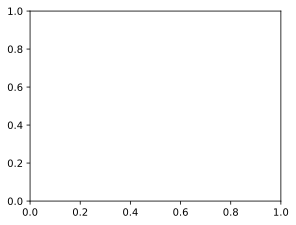

In [31]:
n_epochs = 10
train_cnn(net, device, train_loader, test_loader, optimizer, criterion, n_epochs)